# VAE

In [1]:
# import libraries

import torch
import torch.nn as nn

from torchvision import transforms, datasets
import torch.nn.functional as F
import torch.optim as optim


import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

/Users/melnikov/Desktop/study/Skoltech/ML/DiffClassification/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# download datasets

# you can also try transforms.ToTensor() + transforms.Normalize(mean, std) with mean = 0.5, std = 0.5, BUT if you do so, instead of nn.Sigmoid() in the model use nn.Tanh()
transform = transforms.ToTensor()

# download data for training
mnist_data = datasets.MNIST(root='./todata', train=True,
                            download=True, transform = transform)

# set dataloader
data_loader = torch.utils.data.DataLoader(dataset = mnist_data,
                                          batch_size = 64,
                                          shuffle = True)
# download data for test
test_data = datasets.MNIST(root='./data', train=False,
                            download=True, transform = transform)

In [3]:
class ConvVAE(nn.Module):
    def __init__(self, latent_dim):
        super(ConvVAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),  # Output: (32, 28, 28)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 14, 14)
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 7, 7)
            nn.ReLU(),
            nn.Flatten(),  # Flatten the conv features to feed them into the linear layers
            nn.Linear(128 * 7 * 7, 1024),
            nn.ReLU(),
            nn.Linear(1024, latent_dim * 2)  # We need 2 * latent_dim for mean and log-variance
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 7 * 7),
            nn.ReLU(),
            nn.Unflatten(1, (128, 7, 7)),  # Unflatten to bring back into image dimensions for conv layers
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Sigmoid because MNIST is between [0, 1]
        )
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Encoding
        x_encoded = self.encoder(x)
        mu, log_var = x_encoded.chunk(2, dim=-1)  # Split the encoded values into mu and log_var components
        
        # Reparameterization trick
        z = self.reparameterize(mu, log_var)
        
        # Decoding
        x_reconstructed = self.decoder(torch.Tensor(z))
        
        return x_reconstructed, mu, log_var

# Loss function for VAE
def vae_loss(reconstructed_x, x, mu, logvar):
    x = x.view(-1, 1, 28, 28)
    reconstructed_x = reconstructed_x.view(-1, 1, 28, 28)

    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [7]:
def train_model(model, epochs, train_loader, lr=1e-3, device='cuda'):

    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_arr = []

    for epoch in tqdm(range(epochs)):
        loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # Move data to the device
            data = data.to(device)

            # Forward pass
            reconstructed_images, mu, logvar = model(data)

            # Compute loss
            loss = vae_loss(reconstructed_images, data, mu, logvar)
            loss_arr.append(loss)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # if batch_idx % 100 == 0:
            #     print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(mnist_loader.dataset)} "
            #           f"({100. * batch_idx / len(mnist_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}")
        print(f'Epoch {epoch}, Loss: {loss}')
    return loss_arr

In [8]:
device = 'mps'

latent_dim = 6
conv_vae = ConvVAE(latent_dim).to(device)

optimizer = optim.Adam(conv_vae.parameters(), lr=1e-3)

mnist_data = datasets.MNIST(root='./data', train=True,
                            download=True, transform = transform)

# set dataloader
mnist_loader = torch.utils.data.DataLoader(dataset = mnist_data,
                                          batch_size = 64,
                                          shuffle = True)
# download data for test
test_data = datasets.MNIST(root='./data', train=False,
                            download=True, transform = transform)

# Training loop
epochs = 10
loss_arr = train_model(conv_vae, epochs, mnist_loader, device=device)


# Save the trained model
# torch.save(conv_vae.state_dict(), 'conv_vae_mnist.pth')

print("Training complete")

 10%|█         | 1/10 [00:27<04:03, 27.11s/it]

Epoch 0, Loss: 4007.49609375


 20%|██        | 2/10 [00:50<03:17, 24.74s/it]

Epoch 1, Loss: 3868.60791015625


 30%|███       | 3/10 [01:13<02:49, 24.19s/it]

Epoch 2, Loss: 3893.788818359375


 40%|████      | 4/10 [01:37<02:24, 24.11s/it]

Epoch 3, Loss: 3340.982177734375


 50%|█████     | 5/10 [02:01<01:59, 23.84s/it]

Epoch 4, Loss: 3519.8935546875


 60%|██████    | 6/10 [02:24<01:34, 23.58s/it]

Epoch 5, Loss: 3633.444091796875


 70%|███████   | 7/10 [02:47<01:10, 23.64s/it]

Epoch 6, Loss: 3057.557373046875


 80%|████████  | 8/10 [03:11<00:47, 23.64s/it]

Epoch 7, Loss: 3912.3291015625


 90%|█████████ | 9/10 [03:35<00:23, 23.68s/it]

Epoch 8, Loss: 3248.60791015625


100%|██████████| 10/10 [03:58<00:00, 23.86s/it]

Epoch 9, Loss: 3439.795654296875
Training complete


In [270]:
# latent_dim = 
conv_vae = ConvVAE(latent_dim).to('cpu')
conv_vae.load_state_dict(torch.load('conv_vae_mnist.pth', map_location='cpu'))

<All keys matched successfully>

# TRAIN AND TEST VAE

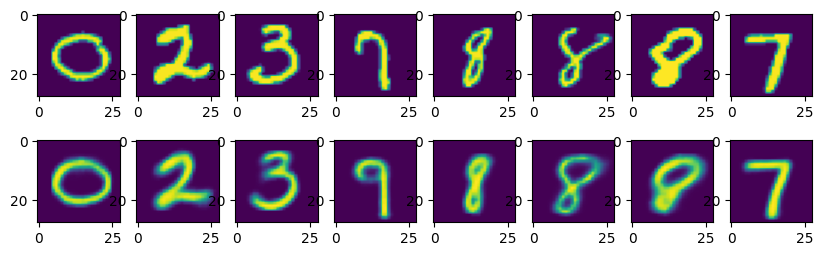

In [271]:
conv_vae.eval()

# Assuming 'test_data' is your MNIST test dataset
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8, shuffle=True)

conv_vae.to('cpu')

data = torch.Tensor(next(iter(test_loader))[0]).to('cpu')


# Forward pass through the model
with torch.no_grad():
    reconstructed_images, _, _ = conv_vae(data)

recov = []
origin = []
for i in range(8):
  origin.append(data[i].reshape(28,28))
  recov.append(reconstructed_images[i].reshape(28,28))

fig, ax = plt.subplots(nrows=2, ncols =8, figsize=(10,3))

for i in range(8):
  ax[0,i].imshow(origin[i].squeeze())
  ax[1,i].imshow(recov[i])

In [272]:
print(conv_vae.encoder.modules)
print(conv_vae.decoder.modules)

<bound method Module.modules of Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=6272, out_features=1024, bias=True)
  (8): ReLU()
  (9): Linear(in_features=1024, out_features=12, bias=True)
)>
<bound method Module.modules of Sequential(
  (0): Linear(in_features=6, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=6272, bias=True)
  (3): ReLU()
  (4): Unflatten(dim=1, unflattened_size=(128, 7, 7))
  (5): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (6): ReLU()
  (7): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (8): ReLU()
  (9): ConvTranspose2d(32, 1, 

In [273]:
activations_encoder = {
    'layer1' : None, 
    'layer2' : None, 
    'layer3' : None, 
    'layer4' : None,
}

activations_decoder = {
    'layer1' : None, 
    'layer2' : None, 
    'layer3' : None, 
    'layer4' : None,
}
# activations_encoder = {}
def get_activation_foo(name, activations):
    def hookFoo(model, input, output):
        if activations[name] == None: 
            activations[name] = output.detach()
        else:
            activations[name] = torch.cat((activations[name], output.detach()), 0)
    return hookFoo

def get_activation_foo_input(name, activations):
    def hookFoo(model, input, output):
        if activations[name] == None: 
            activations[name] = input[0].detach()
        else:
            activations[name] = torch.cat((activations[name], input[0].detach()), 0)
    return hookFoo

conv_vae.encoder[0].register_forward_hook(get_activation_foo('layer1', activations_encoder))
conv_vae.encoder[2].register_forward_hook(get_activation_foo('layer2', activations_encoder))
conv_vae.encoder[4].register_forward_hook(get_activation_foo('layer3', activations_encoder))
conv_vae.encoder[9].register_forward_hook(get_activation_foo('layer4', activations_encoder))

conv_vae.decoder[0].register_forward_hook(get_activation_foo_input('layer1', activations_decoder))
conv_vae.decoder[5].register_forward_hook(get_activation_foo_input('layer2', activations_decoder))
conv_vae.decoder[7].register_forward_hook(get_activation_foo_input('layer3', activations_decoder))
conv_vae.decoder[9].register_forward_hook(get_activation_foo_input('layer4', activations_decoder))

In [274]:
activations_encoder

{'layer1': None, 'layer2': None, 'layer3': None, 'layer4': None}

In [ ]:
for batch_idx, (data, _) in enumerate(mnist_loader):
        with torch.no_grad():
                reconstructed_images, mu, logvar = conv_vae(data)

In [283]:
activations_encoder['layer2'].shape

torch.Size([18368, 64, 14, 14])

In [286]:
activations_encoder['layer2'].mean(dim=2).shape

torch.Size([18368, 64, 14])

In [287]:
import sys
sys.path.append('../')
from pycore.tikzeng import *

ModuleNotFoundError: No module named 'pycore'

In [2]:
def epoch_train(loader, clf, criterion, opt):
    # BEGIN Solution (do not delete this comment!)
    clf.train(True)

    total_loss = 0
    total_accuracy = 0

    for batch, targets in loader:
        batch, targets = batch.to('mps'), targets.to('mps')
        opt.zero_grad()
        predict_targets = clf(batch)
        loss = criterion(predict_targets, targets)
        loss.backward()
        opt.step()

        total_loss += loss.item()
        total_accuracy += torch.sum(predict_targets.argmax(dim = 1) == targets).item()

    return total_loss/len(loader), total_accuracy/len(loader.dataset)

    # END Solution (do not delete this comment!)

def epoch_test(loader, clf, criterion):
    # BEGIN Solution (do not delete this comment!)
    clf.eval()

    total_loss = 0
    total_accuracy = 0

    with torch.no_grad():
        for batch, targets in loader:
            batch, targets = batch.cuda(), targets.cuda()
            predict_targets = clf(batch)
            loss = criterion(predict_targets, targets)

            total_loss += loss.item()
            total_accuracy += torch.sum(predict_targets.argmax(dim = 1) == targets).item()

    return total_loss/len(loader), total_accuracy/len(loader.dataset)

    # END Solution (do not delete this comment!)

# The function which you are going to use for model training
def train(train_loader, test_loader, clf, criterion, opt, n_epochs=50):
    for epoch in tqdm(range(n_epochs)):
        train_loss, train_acc = epoch_train(train_loader, clf, criterion, opt)
        test_loss, test_acc = epoch_test(test_loader, clf, criterion)

        print(f'[Epoch {epoch + 1}] train loss: {train_loss:.3f}; train acc: {train_acc:.2f}; ' +
              f'test loss: {test_loss:.3f}; test acc: {test_acc:.2f}')

In [3]:
import pandas as pd
from smallnet import LinearNet, Net, split_dataset

data = pd.read_csv('data_decoder_20_dim.csv')

In [4]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn, optim
import torch
import numpy as np

class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

In [5]:
data = pd.read_csv('data_encoder_20_dim.csv')
targets = data.y
X = data.drop(['y', 'i'], axis=1)
X.columns = np.arange(0, X.shape[1], 1)
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size=0.2, random_state=42)

X_train = torch.from_numpy(X_train.to_numpy()).to(torch.float32)
y_train = torch.from_numpy(y_train.to_numpy()).to(torch.float32)
X_test = torch.from_numpy(X_test.to_numpy()).to(torch.float32)
y_test = torch.from_numpy(y_test.to_numpy()).to(torch.float32)

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [6]:
from tqdm import tqdm
input_size = X.shape[1]
num_classes = 10

model = LinearNet(input_size, num_classes).to('mps')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(train_loader, test_loader, model, criterion, optimizer, n_epochs=20)

  0%|          | 0/20 [00:00<?, ?it/s]

: 